In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import vgg16_bn
import PIL
import imageio
from superres import *
from scipy.ndimage.interpolation import zoom as npzoom
from skimage.util import img_as_float32, img_as_ubyte
from skimage.measure import compare_ssim, compare_psnr

In [2]:
torch.cuda.set_device(0)

In [3]:
img_data = Path('/scratch/bpho/datasets/emsynth_003/')
model_path = Path('/scratch/bpho/models')


In [5]:
!ls {model_path}/emsynth_003*

/scratch/bpho/models/emsynth_003_unet.0.pth
/scratch/bpho/models/emsynth_003_unet.1.pth


In [6]:
def get_src():
    hr_tifs = img_data/f'hr'
    lr_tifs = img_data/f'lr_up'

    def map_to_hr(x):
        hr_name = x.relative_to(lr_tifs)
        return hr_tifs/hr_name
    print(lr_tifs)
    src = (ImageImageList
            .from_folder(lr_tifs)
            .split_by_rand_pct()
            .label_from_func(map_to_hr))
    return src


def get_data(bs, size, noise=None, max_zoom=1.1):
    src = get_src()
    tfms = get_transforms(flip_vert=True, max_zoom=max_zoom)
    data = (src
            .transform(tfms, size=size)
            .transform_y(tfms, size=size)
            .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data


In [7]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

In [8]:
base_loss = F.l1_loss

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [9]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [ ]:
bs = 64
size = 128
data = get_data(bs, size, max_zoom=6)
data

In [ ]:
data.show_batch(3, ds_type=DatasetType.Valid)

In [ ]:
arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [10]:
lr = 1e-3

In [11]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9, cycle_len=10):
    learn.fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)
    num_rows = min(learn.data.batch_size, 3)
    learn.show_results(rows=num_rows, imgsize=5)

In [ ]:
do_fit('emsynth_003_unet.0', lr, cycle_len=1)

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('emsynth_003_unet.1', slice(1e-5,lr), cycle_len=1)

In [12]:
bs = 16
size = 256
data = get_data(bs, size, max_zoom=3)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('emsynth_003_unet.1')

/scratch/bpho/datasets/emsynth_003/lr_up


/home/fredmonroe/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.967130,0.962646,0.047905,0.480295,13.202960,0.171258,0.194716,0.195190,0.039760,0.134787,0.204906,0.022029,42:36
1,0.954531,0.944845,0.048374,0.482712,13.160541,0.172288,0.192916,0.190736,0.039155,0.127328,0.200791,0.021631,43:25
2,0.933218,0.919537,0.046160,0.489508,13.364337,0.167672,0.191503,0.187884,0.038550,0.119453,0.193171,0.021303,45:50


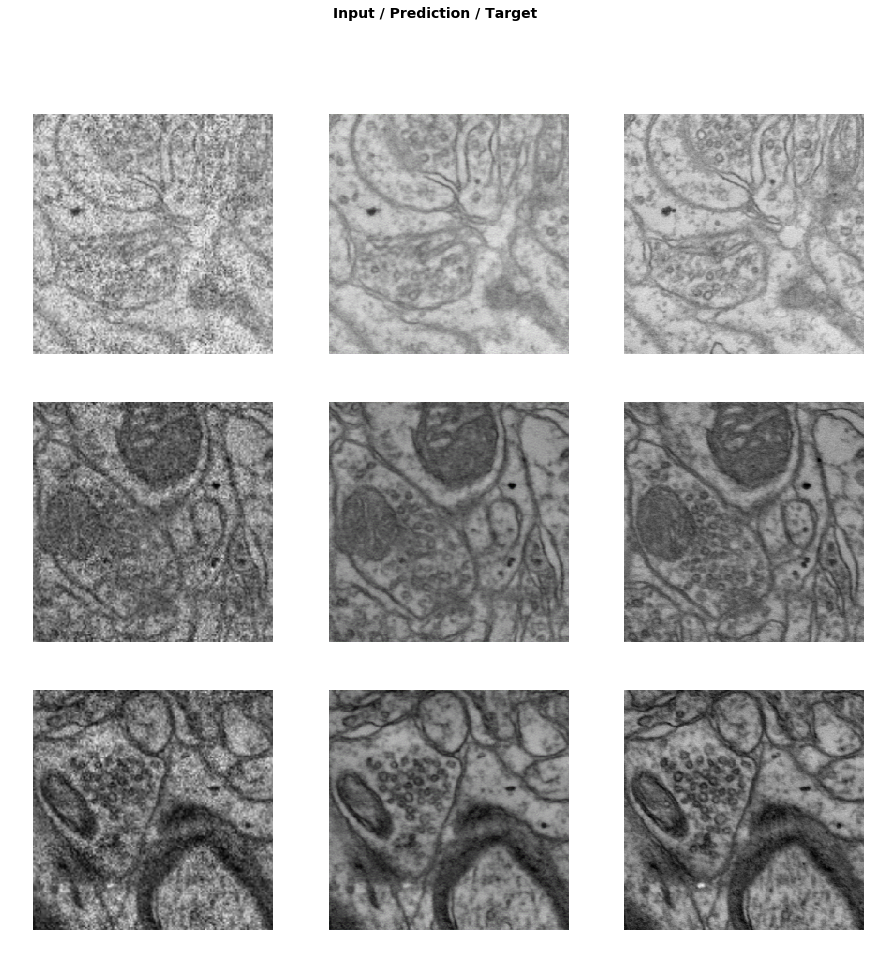

In [13]:
do_fit('emsynth_003_unet.2', lr, cycle_len=3)

In [14]:
learn.unfreeze()

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.921495,0.926421,0.046068,0.486371,13.372895,0.167745,0.191843,0.189561,0.038757,0.121819,0.195277,0.021418,45:49
1,0.924288,0.923655,0.046278,0.490000,13.353270,0.167716,0.191277,0.188252,0.038566,0.120766,0.195780,0.021298,45:42
2,0.912172,0.908429,0.045738,0.492134,13.404320,0.166694,0.190307,0.185762,0.038141,0.116153,0.190263,0.021108,45:45


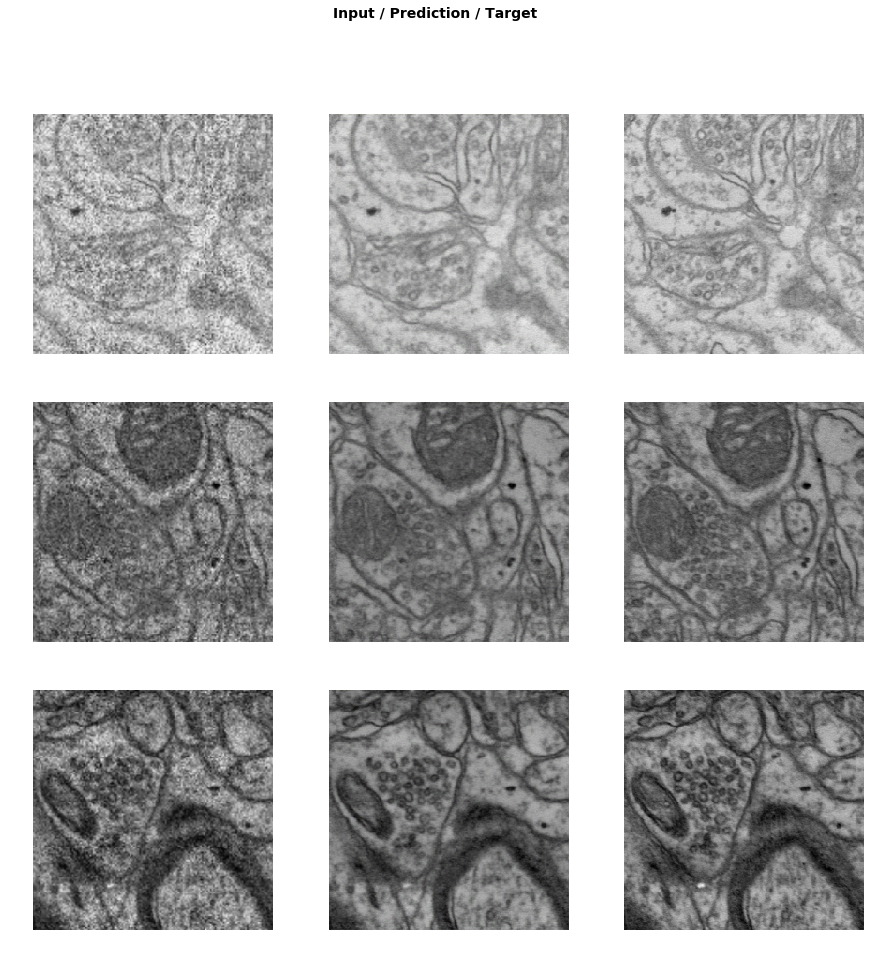

In [15]:
do_fit('emsynth_003_unet.3', slice(1e-5,lr), cycle_len=3)

In [23]:
bs = 2 
size = 512
data = get_data(bs, size, max_zoom=2.)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('emsynth_003_unet.3')

/scratch/bpho/datasets/emsynth_003/lr_up


/home/fredmonroe/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.902868,0.816827,0.066286,0.263244,11.841769,0.201444,0.205171,0.171639,0.024394,0.104476,0.102222,0.007481,2:52:17
1,0.801631,0.808453,0.065750,0.263146,11.882685,0.200703,0.203280,0.172997,0.024744,0.097935,0.101255,0.007539,2:52:10
2,0.789261,0.795136,0.065401,0.266963,11.909326,0.200043,0.202048,0.171938,0.024698,0.091317,0.097653,0.007438,2:52:13


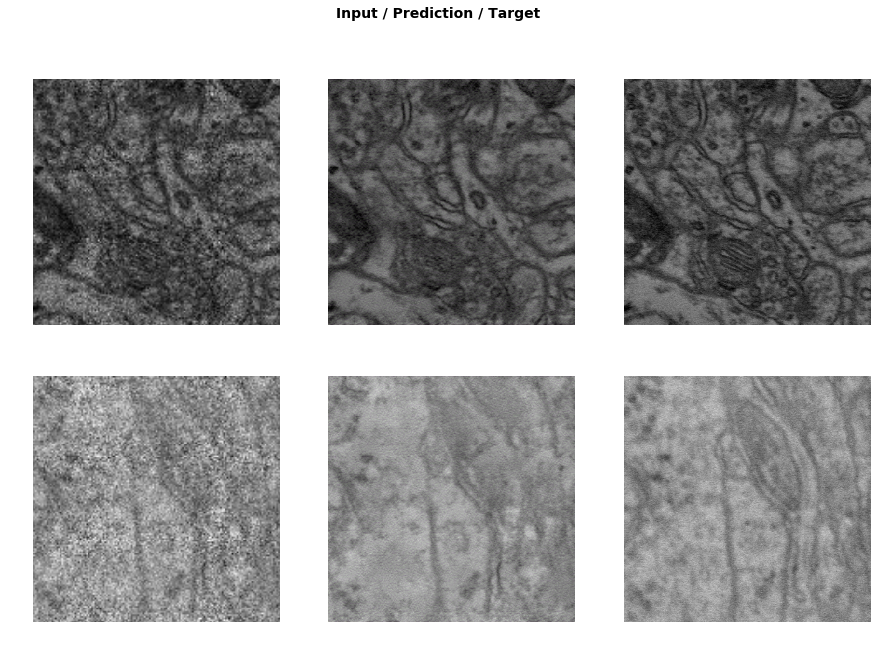

In [24]:
do_fit('emsynth_003_unet.4', lr/10, cycle_len=3)

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('emsynth_003_unet.5', slice(1e-5,lr/10), cycle_len=3)

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time


In [ ]:
bs = 2
size = 1024
data = get_data(bs, size, max_zoom=1.5)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('emsynth_003_unet5')

In [ ]:
do_fit('emsynth_003_unet.6', lr/100000, cycle_len=4)

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('emsynth_003_unet.7', slice(1e-5,lr), cycle_len=10)

In [ ]:
bs = 1
size = 1024
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('emsynth_003_unet.6').to_fp16()

In [ ]:
learn.unfreeze()
do_fit('emsynth_003_unet.8', slice(1e-6,1e-5), cycle_len=10)

In [ ]:
do_fit('emsynth_003_unet.9', slice(1e-6,1e-5), cycle_len=1)

In [ ]:
!ls /scratch/bpho/models

In [17]:
bs = 1
size = 1920
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('emsynth_003_unet.3')

/scratch/bpho/datasets/emsynth_003/lr_up


/home/fredmonroe/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [18]:
test_files = Path('/scratch/bpho/datasources/EM_manually_aquired_pairs_01242019/')
test_hr = list((test_files/'aligned_hr').glob('*.tif'))
test_lr = list((test_files/'aligned_lr').glob('*.tif'))
results = Path('/scratch/bpho/results/emsynth_crap')

if results.exists(): shutil.rmtree(results)
results.mkdir(parents=True, mode=0o775, exist_ok=True)

def get_key(fn):
    return fn.stem[0:(fn.stem.find('Region')-1)]

hr_map = { get_key(fn): fn for fn in test_hr }
lr_map = { get_key(fn): fn for fn in test_lr }


In [19]:
ssims = []
psnrs = []
for k in progress_bar(hr_map):
    hr_fn, lr_fn = hr_map[k], lr_map[k]
    hr_img = PIL.Image.open(hr_fn)
    lr_img = PIL.Image.open(lr_fn)
    lr_img_data = img_as_float32(lr_img)
    lr_up_data = npzoom(lr_img_data, 4, order=1)
    lr_up_img = Image(tensor(lr_up_data[None]))
    hr_pred_img, aaa, bbb = learn.predict(lr_up_img)
    pred_img = PIL.Image.fromarray(img_as_ubyte(np.array(hr_pred_img.data))[0,:,:])
    
    lr_img.save(results/f'{k}_orig.tif')
    hr_img.save(results/f'{k}_truth.tif')
    pred_img.save(results/f'{k}_pred.tif')
    hr_img_data = np.array(hr_img)
    
    ssims.append(compare_ssim(img_as_float32(np.array(hr_img)), img_as_float32(np.array(pred_img))))
    psnrs.append(compare_psnr(img_as_float32(np.array(hr_img)), img_as_float32(np.array(pred_img))))

/home/fredmonroe/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [20]:
np.array(ssims).mean(), np.array(psnrs).mean()

(0.7499132242134703, 20.20805024486801)

In [22]:
import skimage.io as io

#target_path = Path('/DATA/Dropbox/bpho_movie_results/emsynth_003/')
target_path = results

orig,tru,pred = [list(target_path.glob(f'*{tag}*')) for tag in ['orig','tru','pred']]
orig.sort()
tru.sort()
pred.sort()


ssims = []
c_ssims = []
l_ssims = []
psnrs = []
c_psnrs = []
l_psnrs = []

for o, t,p in progress_bar(list(zip(orig, tru,pred))):
    oimg, timg, pimg = [img_as_float32(io.imread(fn)) for fn in [o,t,p]]
    if len(pimg.shape) == 3: pimg = pimg[:,:,0]
    cimg = npzoom(oimg, 4)
    limg = npzoom(oimg, 4, order=1)
    
    ssims.append(compare_ssim(timg, pimg))
    c_ssims.append(compare_ssim(timg, cimg))
    l_ssims.append(compare_ssim(timg, limg))
    psnrs.append(compare_psnr(timg, pimg))
    c_psnrs.append(compare_psnr(timg, cimg))
    l_psnrs.append(compare_psnr(timg, limg))
    
import pandas as pd

df = pd.DataFrame(dict(ssim=ssims, psnr=psnrs, 
                        bicubic_ssim=c_ssims, bicubic_psnr=c_psnrs,
                        bilinear_ssim=l_ssims, bilinear_psnr=l_psnrs))

df.describe()

,ssim,psnr,bicubic_ssim,bicubic_psnr,bilinear_ssim,bilinear_psnr
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,0.749913,20.208050,0.692300,19.892473,0.730810,20.155426
std,0.033936,3.527335,0.036899,3.397313,0.036152,3.544903
min,0.680233,14.148038,0.620273,14.207584,0.658729,14.275473
25%,0.723769,16.721926,0.662589,16.520311,0.702204,16.623836
50%,0.761611,19.801758,0.705555,19.531696,0.744095,19.738787
75%,0.778708,23.603625,0.724061,23.139879,0.761960,23.557128
max,0.802228,24.813916,0.746718,24.248150,0.785502,24.759367
